# Kaggle Spectrograms vs. EEG Spectrograms
In this competition, Kaggle provides us with both spectrograms and raw eeg waveforms. The Kaggle spectrograms are 10 minutes long and the eeg waveforms are 50 seconds. The middle 50 seconds of both data are the same time window observing the same event. (i.e. the middle 50 seconds is same information displayed two different ways). Spectrograms are just visual representations of raw waveforms.

I published a spectrogram starter notebook [here][1] that converts the raw eeg waveform into a spectrogram. There is a discussion [here][3]. The eeg spectrograms (from version 4) have been uploaded to my Kaggle dataset [here][2]. Version 4 (of my spectrogram starter notebook) onward uses a new powerful formula. The below table shows that the new created eeg spectrograms are equal or better than the Kaggle spectrograms:

| Spectrogram | EffNet 5Fold CV | EffNet LB | Notebook version | Model | Loss | Epochs | Data Augmention |
| --- | --- | --- | --- | --- | --- | --- | --- |
| Kaggle Spectrograms | 0.73 | 0.57 | ver 1 | EffNetB2 | CE | 3 | none |
| Kaggle Spectrograms | 0.66 | ??? | ver 4 | EffNetB0 | KL-Div | 4 | none |
| EEG Spectrograms | 0.63 | ??? | ver 3 | EffNetB0 | KL-Div | 4 | none |
| **Both Spectrograms** | **0.59** | **0.44** | ver 5| EffNetB0 | KL-Div | 4 | none |


In different versions of this (efficientnet starter) notebook, we will train three EfficientNet models. Version 3 is using only EEG spectrograms. Version 4 is using only Kaggle spectrograms. And version 5 is a single model using both EEG spectrograms and Kaggle spectrograms. Then we save the model weights into a Kaggle dataset [here][4] and we make a submit notebook in version 6 for the version 5 model trained on both spectrograms. We achieve **CV 0.59 LB 0.44**! Wow!

[1]: https://www.kaggle.com/code/cdeotte/how-to-make-spectrogram-from-eeg
[2]: https://www.kaggle.com/datasets/cdeotte/brain-eeg-spectrograms
[3]: https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/469760
[4]: https://www.kaggle.com/datasets/cdeotte/brain-efficientnet-models-v3-v4-v5

# Initialize 2xT4 GPUs
We will use both Kaggle T4 GPUs and we will use mixed precision.

In [2]:
import os, gc
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
import tensorflow as tf
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
print('TensorFlow version =',tf.__version__)

# USE MULTIPLE GPUS
gpus = tf.config.list_physical_devices('GPU')
if len(gpus)<=1: 
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    print(f'Using {len(gpus)} GPU')
else: 
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')

VER = 5

# IF THIS EQUALS NONE, THEN WE TRAIN NEW MODELS
# IF THIS EQUALS DISK PATH, THEN WE LOAD PREVIOUSLY TRAINED MODELS
LOAD_MODELS_FROM = '/kaggle/input/my-models/'
#'/kaggle/input/brain-efficientnet-models-v3-v4-v5/'

USE_KAGGLE_SPECTROGRAMS = True
USE_EEG_SPECTROGRAMS = True

TensorFlow version = 2.13.0
Using 2 GPUs


In [3]:
# USE MIXED PRECISION
MIX = True
if MIX:
    tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
    print('Mixed precision enabled')
else:
    print('Using full precision')

Mixed precision enabled


# Load Train Data

In [4]:
df = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
TARGETS = df.columns[-6:]
print('Train shape:', df.shape )
print('Targets', list(TARGETS))
df.head()

Train shape: (106800, 15)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


# Create Non-Overlapping Eeg Id Train Data
The competition data description says that test data does not have multiple crops from the same `eeg_id`. Therefore we will train and validate using only 1 crop per `eeg_id`. There is a discussion about this [here][1].

[1]: https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/467021

In [5]:
train = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_id':'first','spectrogram_label_offset_seconds':'min'})
train.columns = ['spec_id','min']

tmp = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_label_offset_seconds':'max'})
train['max'] = tmp

tmp = df.groupby('eeg_id')[['patient_id']].agg('first')
train['patient_id'] = tmp

tmp = df.groupby('eeg_id')[TARGETS].agg('sum')
for t in TARGETS:
    train[t] = tmp[t].values
    
y_data = train[TARGETS].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train[TARGETS] = y_data

tmp = df.groupby('eeg_id')[['expert_consensus']].agg('first')
train['target'] = tmp

train = train.reset_index()
print('Train non-overlapp eeg_id shape:', train.shape )
train.head()

Train non-overlapp eeg_id shape: (17089, 12)


,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other


# Read Train Spectrograms 

First we need to read in all 11k train spectrogram files. Reading thousands of files takes 11 minutes with Pandas. Instead, we can read 1 file from my [Kaggle dataset here][1] which contains all the 11k spectrograms in less than 1 minute! To use my Kaggle dataset, set variable `READ_SPEC_FILES = False`. Thank you for upvoting my helpful [dataset][1] :-)

[1]: https://www.kaggle.com/datasets/cdeotte/brain-spectrograms

In [6]:
%%time
READ_SPEC_FILES = False

# READ ALL SPECTROGRAMS
PATH = '/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/'
files = os.listdir(PATH)
print(f'There are {len(files)} spectrogram parquets')

if READ_SPEC_FILES:    
    spectrograms = {}
    for i,f in enumerate(files):
        if i%100==0: print(i,', ',end='')
        tmp = pd.read_parquet(f'{PATH}{f}')
        name = int(f.split('.')[0])
        spectrograms[name] = tmp.iloc[:,1:].values
else:
    spectrograms = np.load('/kaggle/input/brain-spectrograms/specs.npy',allow_pickle=True).item()

There are 11138 spectrogram parquets
CPU times: user 2.84 s, sys: 6.02 s, total: 8.86 s
Wall time: 1min 12s


# Read EEG Spectrograms
In version 4 onward, we use EEG spectrograms in addition to Kaggle spectrograms. The EEG spectrograms come from my Kaggle dataset [here][4] (which were created from my spectrogram starter [here][5]). Thank you for upvoting my Kaggle dataset!

[4]: https://www.kaggle.com/datasets/cdeotte/brain-eeg-spectrograms
[5]: https://www.kaggle.com/code/cdeotte/how-to-make-spectrogram-from-eeg

In [7]:
%%time
READ_EEG_SPEC_FILES = False

if READ_EEG_SPEC_FILES:
    all_eegs = {}
    for i,e in enumerate(train.eeg_id.values):
        if i%100==0: print(i,', ',end='')
        x = np.load(f'/kaggle/input/brain-eeg-spectrograms/EEG_Spectrograms/{e}.npy')
        all_eegs[e] = x
else:
    all_eegs = np.load('/kaggle/input/brain-eeg-spectrograms/eeg_specs.npy',allow_pickle=True).item()

CPU times: user 4.28 s, sys: 8.24 s, total: 12.5 s
Wall time: 1min 31s


# Train DataLoader
This dataloader outputs 4 spectrogram images as a 4 channel image of size 128x256x4 per train sample. This notebook version is not using data augmention but the code is available below to experiment with albumentations data augmention. Just add `augment = True` when creating the train data loader. And consider adding new transformations to the augment function below.

UPDATE: In version 4 onward, our dataloader outputs both Kaggle spectrograms and EEG spectrogams as 8 channel image of size 128x256x8.

In [8]:
import albumentations as albu
TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}
TARS2 = {x:y for y,x in TARS.items()}

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, batch_size=32, shuffle=False, augment=False, mode='train',
                 specs = spectrograms, eeg_specs = all_eegs): 

        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.mode = mode
        self.specs = specs
        self.eeg_specs = eeg_specs
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        ct = int( np.ceil( len(self.data) / self.batch_size ) )
        return ct

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        if self.augment: X = self.__augment_batch(X) 
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange( len(self.data) )
        if self.shuffle: np.random.shuffle(self.indexes)
                        
    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' 
        
        X = np.zeros((len(indexes),128,256,8),dtype='float32')
        y = np.zeros((len(indexes),6),dtype='float32')
        img = np.ones((128,256),dtype='float32')
        
        for j,i in enumerate(indexes):
            row = self.data.iloc[i]
            if self.mode=='test': 
                r = 0
            else: 
                r = int( (row['min'] + row['max'])//4 )

            for k in range(4):
                # EXTRACT 300 ROWS OF SPECTROGRAM
                img = self.specs[row.spec_id][r:r+300,k*100:(k+1)*100].T
                
                # LOG TRANSFORM SPECTROGRAM
                img = np.clip(img,np.exp(-4),np.exp(8))
                img = np.log(img)
                
                # STANDARDIZE PER IMAGE
                ep = 1e-6
                m = np.nanmean(img.flatten())
                s = np.nanstd(img.flatten())
                img = (img-m)/(s+ep)
                img = np.nan_to_num(img, nan=0.0)
                
                # CROP TO 256 TIME STEPS
                X[j,14:-14,:,k] = img[:,22:-22] / 2.0
        
            # EEG SPECTROGRAMS
            img = self.eeg_specs[row.eeg_id]
            X[j,:,:,4:] = img
                
            if self.mode!='test':
                y[j,] = row[TARGETS]
            
        return X,y
    
    def __random_transform(self, img):
        composition = albu.Compose([
            albu.HorizontalFlip(p=0.5),
            albu.CoarseDropout(max_holes=8,max_height=32,max_width=32,fill_value=0,p=0.5),
        ])
        return composition(image=img)['image']
            
    def __augment_batch(self, img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i, ] = self.__random_transform(img_batch[i, ])
        return img_batch

# Display DataLoader
Below we display example dataloader spectrogram images.

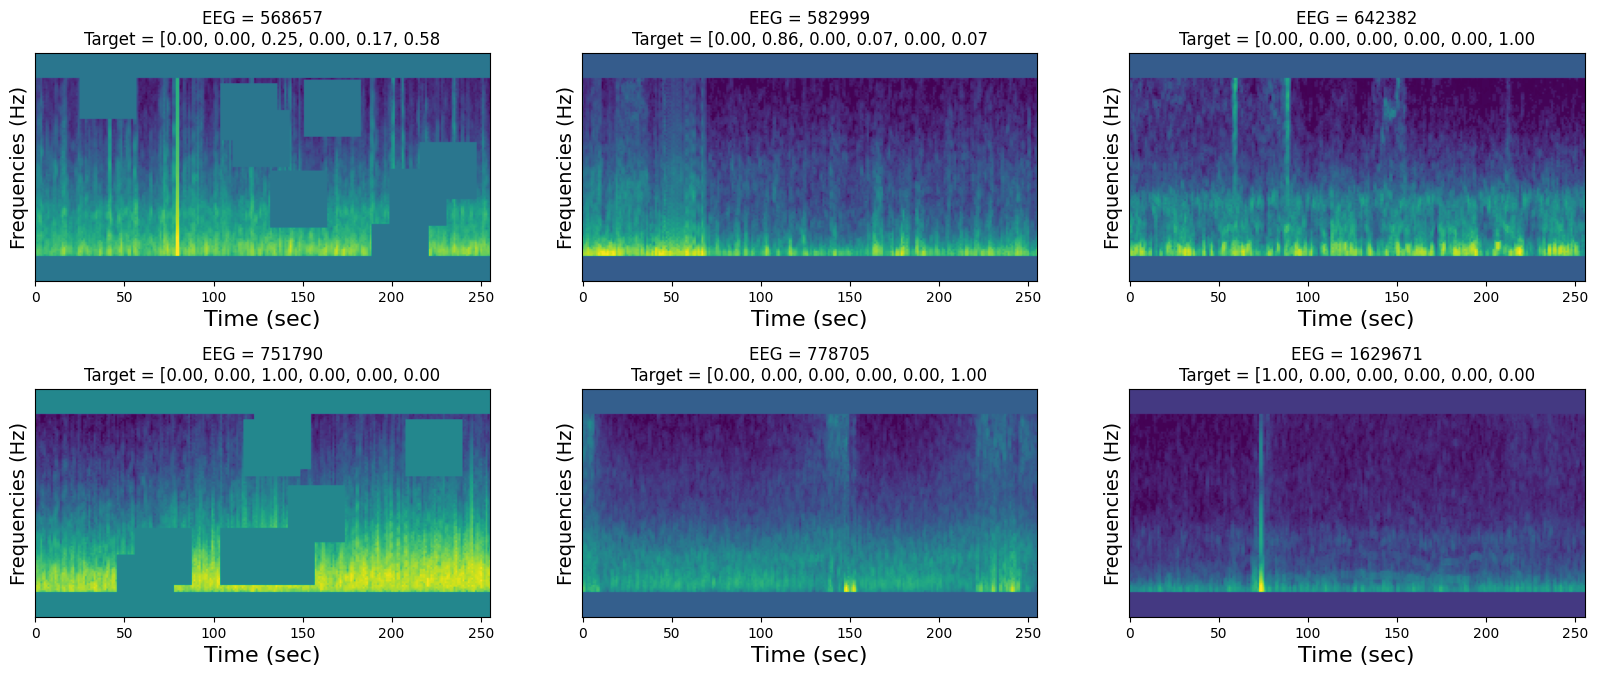

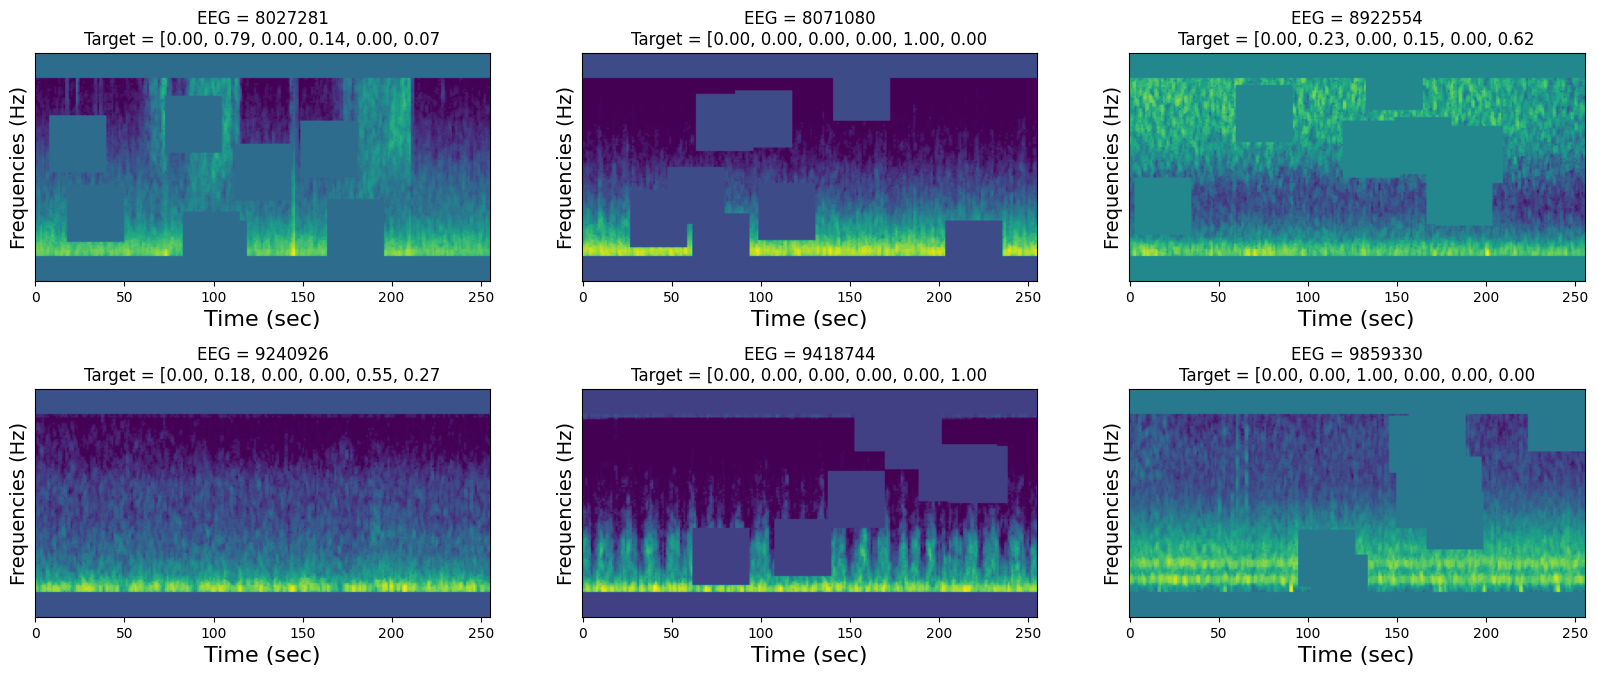

In [9]:
gen = DataGenerator(train, batch_size=32, shuffle=False,augment=True)
ROWS=2; COLS=3; BATCHES=2

for i,(x,y) in enumerate(gen):
    plt.figure(figsize=(20,8))
    for j in range(ROWS):
        for k in range(COLS):
            plt.subplot(ROWS,COLS,j*COLS+k+1)
            t = y[j*COLS+k]
            img = x[j*COLS+k,:,:,0][::-1,]
            mn = img.flatten().min()
            mx = img.flatten().max()
            img = (img-mn)/(mx-mn)
            plt.imshow(img)
            tars = f'[{t[0]:0.2f}'
            for s in t[1:]: tars += f', {s:0.2f}'
            eeg = train.eeg_id.values[i*32+j*COLS+k]
            plt.title(f'EEG = {eeg}\nTarget = {tars}',size=12)
            plt.yticks([])
            plt.ylabel('Frequencies (Hz)',size=14)
            plt.xlabel('Time (sec)',size=16)
    plt.show()
    if i==BATCHES-1: break

# Train Scheduler
We will train our model with a Step Train Schedule for 4 epochs. First 2 epochs are LR=1e-3. Then epochs 3 and 4 use LR=1e-4 and 1e-5 respectively. (Below we also provide a Cosine Train Schedule if you want to experiment with it. Note it is not used in this notebook).

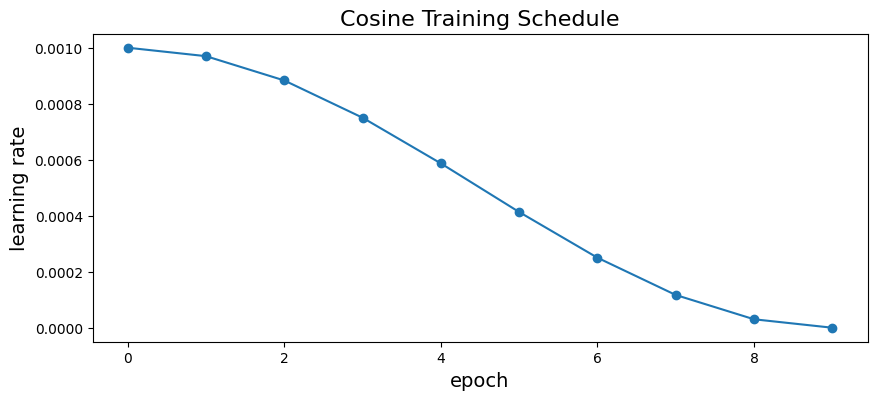

In [10]:
import math
LR_START = 1e-6
LR_MAX = 1e-3
LR_MIN = 1e-6
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 0
EPOCHS2 = 10

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        decay_total_epochs = EPOCHS2 - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
        decay_epoch_index = epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
        phase = math.pi * decay_epoch_index / decay_total_epochs
        cosine_decay = 0.5 * (1 + math.cos(phase))
        lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN
    return lr

rng = [i for i in range(EPOCHS2)]
lr_y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, lr_y, '-o')
plt.xlabel('epoch',size=14); plt.ylabel('learning rate',size=14)
plt.title('Cosine Training Schedule',size=16); plt.show()

LR2 = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

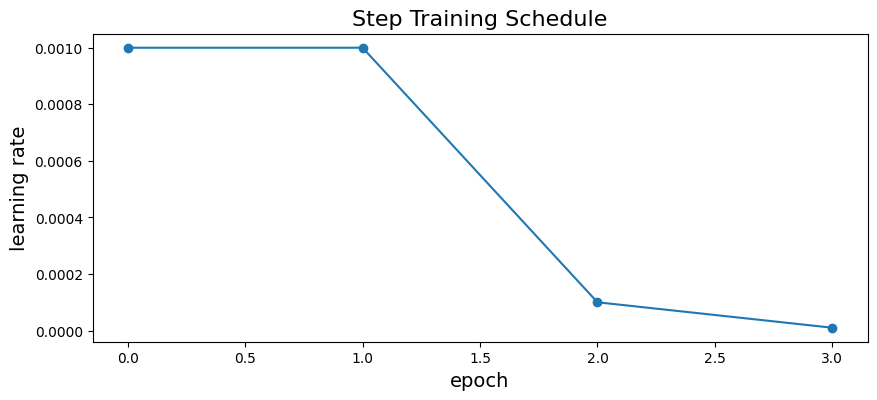

In [11]:
LR_START = 1e-4
LR_MAX = 1e-3
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 1
LR_STEP_DECAY = 0.1
EVERY = 1
EPOCHS = 4

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = LR_MAX * LR_STEP_DECAY**((epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)//EVERY)
    return lr

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, y, 'o-'); 
plt.xlabel('epoch',size=14); plt.ylabel('learning rate',size=14)
plt.title('Step Training Schedule',size=16); plt.show()

LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

## Build EfficientNet Model
Version 1-3 uses EfficientNet B2. Version 4 uses EfficientNet B0. Our models receives both Kaggle spectrograms and EEG spectrograms from our data loader. We then reshape these 8 spectrograms into 1 large flat image and feed it into EfficientNet.

In [12]:
!pip install --no-index --find-links=/kaggle/input/tf-efficientnet-whl-files /kaggle/input/tf-efficientnet-whl-files/efficientnet-1.1.1-py3-none-any.whl

Looking in links: /kaggle/input/tf-efficientnet-whl-files
Processing /kaggle/input/tf-efficientnet-whl-files/efficientnet-1.1.1-py3-none-any.whl
Processing /kaggle/input/tf-efficientnet-whl-files/Keras_Applications-1.0.8-py3-none-any.whl (from efficientnet==1.1.1)


In [13]:
import efficientnet.tfkeras as efn

def build_model(size):
    
    inp = tf.keras.Input(shape=(128,256,8))
    if size==0:
        base_model = efn.EfficientNetB0(include_top=False, weights=None, input_shape=None)
    elif size==1:
        base_model = efn.EfficientNetB1(include_top=False, weights=None, input_shape=None)
    elif size==2:
        base_model = efn.EfficientNetB2(include_top=False, weights=None, input_shape=None)
    elif size==3:
        base_model = efn.EfficientNetB3(include_top=False, weights=None, input_shape=None)
    elif size==4:
        base_model = efn.EfficientNetB4(include_top=False, weights=None, input_shape=None) 
    base_model.load_weights(f'/kaggle/input/tf-efficientnet-imagenet-weights/efficientnet-b{size}_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5')
    
    # RESHAPE INPUT 128x256x8 => 512x512x3 MONOTONE IMAGE
    # KAGGLE SPECTROGRAMS
    x1 = [inp[:,:,:,i:i+1] for i in range(4)]
    x1 = tf.keras.layers.Concatenate(axis=1)(x1)
    # EEG SPECTROGRAMS
    x2 = [inp[:,:,:,i+4:i+5] for i in range(4)]
    x2 = tf.keras.layers.Concatenate(axis=1)(x2)
    # MAKE 512X512X3
    if USE_KAGGLE_SPECTROGRAMS & USE_EEG_SPECTROGRAMS:
        x = tf.keras.layers.Concatenate(axis=2)([x1,x2])
    elif USE_EEG_SPECTROGRAMS: x = x2
    else: x = x1
    x = tf.keras.layers.Concatenate(axis=3)([x,x,x])
    
    # OUTPUT
    x = base_model(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(6,activation='softmax', dtype='float32')(x)
        
    # COMPILE MODEL
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
    loss = tf.keras.losses.KLDivergence()

    model.compile(loss=loss, optimizer = opt) 
        
    return model

# Train Model
We train using Group KFold on patient id. If `LOAD_MODELS_FROM = None`, then we will train new models in this notebook version. Otherwise we will load saved models from the path `LOAD_MODELS_FROM`.

In [14]:
from sklearn.model_selection import KFold, GroupKFold
import tensorflow.keras.backend as K, gc

all_oof = []
all_true = []

gkf = GroupKFold(n_splits=5)
for i, (train_index, valid_index) in enumerate(gkf.split(train, train.target, train.patient_id)):  
    
    print('#'*25)
    print(f'### Fold {i+1}')
    
    train_gen = DataGenerator(train.iloc[train_index], shuffle=True, batch_size=8, augment=True)
    valid_gen = DataGenerator(train.iloc[valid_index], shuffle=False, batch_size=8, mode='valid')
    
    print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
    print('#'*25)
    
    K.clear_session()
    with strategy.scope():
        model0 = build_model(0)
        model1 = build_model(1)
        model2 = build_model(2)
        model3 = build_model(3)
        model4 = build_model(4)
    if LOAD_MODELS_FROM is None:
        model.fit(train_gen, verbose=1,
              validation_data = valid_gen,
              epochs=EPOCHS, callbacks = [LR])
        model.save_weights(f'EffNet_v{VER}_f{i}.h5')
    else:
        model0.load_weights(f'{LOAD_MODELS_FROM}EffNet_v{VER}_f{i}.h5')
        model1.load_weights(f'{LOAD_MODELS_FROM}EffNet_v{VER}_f{i} (1).h5')
        model2.load_weights(f'{LOAD_MODELS_FROM}EffNet_v{VER}_f{i} (2).h5')
        model3.load_weights(f'{LOAD_MODELS_FROM}EffNet_v{VER}_f{i} (3).h5')
        model4.load_weights(f'{LOAD_MODELS_FROM}EffNet_v{VER}_f{i} (4).h5')
        
    oof0 = model0.predict(valid_gen, verbose=1)
    oof1 = model1.predict(valid_gen, verbose=1)
    oof2 = model2.predict(valid_gen, verbose=1)
    oof3 = model3.predict(valid_gen, verbose=1)
    oof4 = model4.predict(valid_gen, verbose=1)
    
    oof = (oof0+oof1+oof2+oof3+oof4)/5
    all_oof.append(oof)
    all_true.append(train.iloc[valid_index][TARGETS].values)
    
    del model0,model1,model2,model3,model4,oof0,oof1,oof2,oof3,oof4,oof
    gc.collect()
    
all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)

#########################
### Fold 1
### train size 13671, valid size 3418
#########################
428/428 [==============================] - 37s 71ms/step
#########################
### Fold 2
### train size 13671, valid size 3418
#########################
428/428 [==============================] - 39s 76ms/step
#########################
### Fold 3
### train size 13671, valid size 3418
#########################
428/428 [==============================] - 37s 70ms/step
#########################
### Fold 4
### train size 13671, valid size 3418
#########################
428/428 [==============================] - 37s 70ms/step
#########################
### Fold 5
### train size 13672, valid size 3417
#########################
428/428 [==============================] - 37s 71ms/step


# CV Score for EfficientNet
This is CV score for our EfficientNet model.

In [15]:
import sys
sys.path.append('/kaggle/input/kaggle-kl-div')
from kaggle_kl_div import score

oof = pd.DataFrame(all_oof.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(all_true.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score KL-Div for EfficientNet_Ensemble =',cv)

CV Score KL-Div for EfficientNet_Ensemble = 0.5438979542683975


# Infer Test and Create Submission CSV
Below we use our 5 EfficientNet fold models to infer the test data and create a `submission.csv` file.

In [16]:
del all_eegs, spectrograms; gc.collect()
test = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/test.csv')
print('Test shape',test.shape)
test.head()

Test shape (1, 3)


,spectrogram_id,eeg_id,patient_id
0,853520,3911565283,6885


In [17]:
# READ ALL SPECTROGRAMS
PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/'
files2 = os.listdir(PATH2)
print(f'There are {len(files2)} test spectrogram parquets')
    
spectrograms2 = {}
for i,f in enumerate(files2):
    if i%100==0: print(i,', ',end='')
    tmp = pd.read_parquet(f'{PATH2}{f}')
    name = int(f.split('.')[0])
    spectrograms2[name] = tmp.iloc[:,1:].values
    
# RENAME FOR DATALOADER
test = test.rename({'spectrogram_id':'spec_id'},axis=1)

There are 1 test spectrogram parquets
0 , 

In [18]:
import pywt, librosa

USE_WAVELET = None 

NAMES = ['LL','LP','RP','RR']

FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2']]

# DENOISE FUNCTION
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise(x, wavelet='haar', level=1):    
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    ret=pywt.waverec(coeff, wavelet, mode='per')
    
    return ret

def spectrogram_from_eeg(parquet_path, display=False):
    
    # LOAD MIDDLE 50 SECONDS OF EEG SERIES
    eeg = pd.read_parquet(parquet_path)
    middle = (len(eeg)-10_000)//2
    eeg = eeg.iloc[middle:middle+10_000]
    
    # VARIABLE TO HOLD SPECTROGRAM
    img = np.zeros((128,256,4),dtype='float32')
    
    if display: plt.figure(figsize=(10,7))
    signals = []
    for k in range(4):
        COLS = FEATS[k]
        
        for kk in range(4):
        
            # COMPUTE PAIR DIFFERENCES
            x = eeg[COLS[kk]].values - eeg[COLS[kk+1]].values

            # FILL NANS
            m = np.nanmean(x)
            if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
            else: x[:] = 0

            # DENOISE
            if USE_WAVELET:
                x = denoise(x, wavelet=USE_WAVELET)
            signals.append(x)

            # RAW SPECTROGRAM
            mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=len(x)//256, 
                  n_fft=1024, n_mels=128, fmin=0, fmax=20, win_length=128)

            # LOG TRANSFORM
            width = (mel_spec.shape[1]//32)*32
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)[:,:width]

            # STANDARDIZE TO -1 TO 1
            mel_spec_db = (mel_spec_db+40)/40 
            img[:,:,k] += mel_spec_db
                
        # AVERAGE THE 4 MONTAGE DIFFERENCES
        img[:,:,k] /= 4.0
        
        if display:
            plt.subplot(2,2,k+1)
            plt.imshow(img[:,:,k],aspect='auto',origin='lower')
            plt.title(f'EEG {eeg_id} - Spectrogram {NAMES[k]}')
            
    if display: 
        plt.show()
        plt.figure(figsize=(10,5))
        offset = 0
        for k in range(4):
            if k>0: offset -= signals[3-k].min()
            plt.plot(range(10_000),signals[k]+offset,label=NAMES[3-k])
            offset += signals[3-k].max()
        plt.legend()
        plt.title(f'EEG {eeg_id} Signals')
        plt.show()
        print(); print('#'*25); print()
        
    return img

Converting Test EEG to Spectrograms...



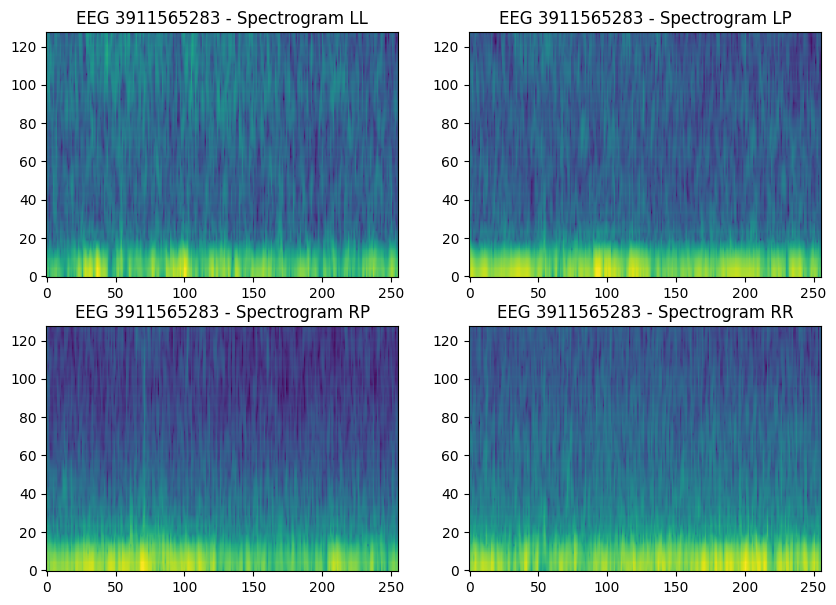

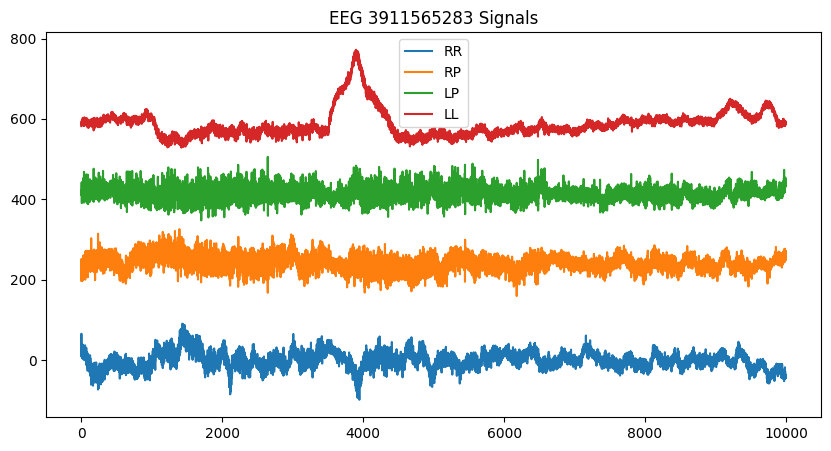


#########################



In [19]:
# READ ALL EEG SPECTROGRAMS
PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/'
DISPLAY = 1
EEG_IDS2 = test.eeg_id.unique()
all_eegs2 = {}

print('Converting Test EEG to Spectrograms...'); print()
for i,eeg_id in enumerate(EEG_IDS2):
        
    # CREATE SPECTROGRAM FROM EEG PARQUET
    img = spectrogram_from_eeg(f'{PATH2}{eeg_id}.parquet', i<DISPLAY)
    all_eegs2[eeg_id] = img

In [20]:
# INFER EFFICIENTNET ON TEST
preds = []
model0 = build_model(0)
model1 = build_model(1)
model2 = build_model(2)
model3 = build_model(3)
model4 = build_model(4)

test_gen = DataGenerator(test, shuffle=False, batch_size=64, mode='test',
                         specs = spectrograms2, eeg_specs = all_eegs2)

for i in range(5):
    print(f'Fold {i+1}')
    if LOAD_MODELS_FROM:
        model0.load_weights(f'{LOAD_MODELS_FROM}EffNet_v{VER}_f{i}.h5')
        model1.load_weights(f'{LOAD_MODELS_FROM}EffNet_v{VER}_f{i} (1).h5')
        model2.load_weights(f'{LOAD_MODELS_FROM}EffNet_v{VER}_f{i} (2).h5')
        model3.load_weights(f'{LOAD_MODELS_FROM}EffNet_v{VER}_f{i} (3).h5')
        model4.load_weights(f'{LOAD_MODELS_FROM}EffNet_v{VER}_f{i} (4).h5')
        
    else:
        model.load_weights(f'EffNet_v{VER}_f{i}.h5')
    pred0 = model0.predict(test_gen, verbose=1)
    pred1 = model1.predict(test_gen, verbose=1)
    pred2 = model2.predict(test_gen, verbose=1)
    pred3 = model3.predict(test_gen, verbose=1)
    pred4 = model4.predict(test_gen, verbose=1)
    pred = (pred0+pred1+pred2+pred3+pred4)/5
    preds.append(pred)
pred = np.mean(preds,axis=0)
print()
print('Test preds shape',pred.shape)

Fold 1
1/1 [==============================] - 3s 3s/step
Fold 2
1/1 [==============================] - 0s 50ms/step
Fold 3
1/1 [==============================] - 0s 50ms/step
Fold 4
1/1 [==============================] - 0s 50ms/step
Fold 5
1/1 [==============================] - 0s 49ms/step

Test preds shape (1, 6)


In [21]:
sub = pd.DataFrame({'eeg_id':test.eeg_id.values})
sub[TARGETS] = pred
sub.to_csv('submission.csv',index=False)
print('Submissionn shape',sub.shape)
sub.head()

Submissionn shape (1, 7)


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.216076,0.058132,0.000819,0.37004,0.04449,0.310443


In [22]:
# SANITY CHECK TO CONFIRM PREDICTIONS SUM TO ONE
sub.iloc[:,-6:].sum(axis=1)

0    1.0
dtype: float32